In [13]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from helper_functions import plot_decision_boundary, plot_predictions

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


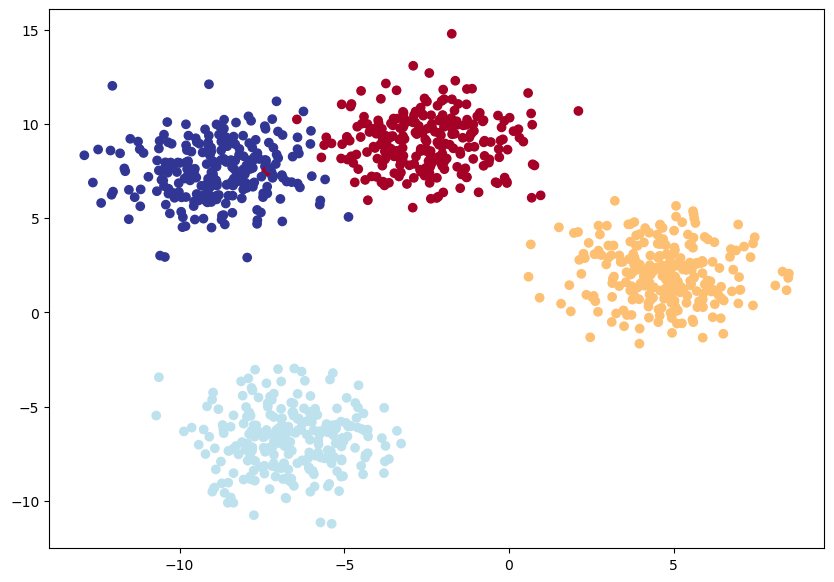

In [2]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [3]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [5]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [6]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-0.5725,  0.3884, -1.1766,  0.2928],
        [-0.2554, -0.2935, -2.8482,  0.4536],
        [ 1.0705,  0.6928,  1.9207,  0.5335],
        [ 0.6601,  0.4860,  0.7464,  0.4935],
        [-0.0920, -0.1702, -2.2551,  0.4631]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [7]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.5978,  0.2984, -1.4855,  0.3023],
        [ 0.2913, -0.3182, -2.2035,  0.5531],
        [ 0.8386,  0.6980,  1.6312,  0.4921],
        [-0.3667,  0.4768, -0.6345,  0.3152],
        [-0.4812, -0.2443, -2.9948,  0.4064]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1582, 0.3876, 0.0651, 0.3891],
        [0.3418, 0.1858, 0.0282, 0.4441],
        [0.2090, 0.1816, 0.4617, 0.1478],
        [0.1648, 0.3831, 0.1261, 0.3260],
        [0.2093, 0.2653, 0.0169, 0.5085]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [8]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [9]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1582, 0.3876, 0.0651, 0.3891], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


In [10]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.01985, Acc: 68.62% | Test Loss: 0.77509, Test Acc: 69.00%
Epoch: 10 | Loss: 0.17508, Acc: 99.12% | Test Loss: 0.16094, Test Acc: 99.50%
Epoch: 20 | Loss: 0.09213, Acc: 99.12% | Test Loss: 0.08427, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06509, Acc: 99.12% | Test Loss: 0.05771, Test Acc: 99.50%
Epoch: 40 | Loss: 0.05248, Acc: 99.12% | Test Loss: 0.04490, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04535, Acc: 99.12% | Test Loss: 0.03752, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04084, Acc: 99.12% | Test Loss: 0.03277, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03776, Acc: 99.12% | Test Loss: 0.02946, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03554, Acc: 99.12% | Test Loss: 0.02704, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03386, Acc: 99.12% | Test Loss: 0.02520, Test Acc: 99.50%


In [11]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  5.3845,  10.7001, -13.8736,  -7.9873],
        [  3.1642, -11.5139,   1.1383,   8.7488],
        [ -8.0645, -12.3367,  19.1665,  10.8441],
        [  2.4145,   8.0434,  -7.8389,  -5.6277],
        [  8.3568,   3.5356, -14.8135,  -3.0778],
        [  3.3779, -14.4274,   2.3157,  10.8770],
        [ -8.0543,  -9.1952,  17.5198,   8.5174],
        [  6.7875,  -0.4332, -10.2934,   0.0675],
        [ -8.7545, -17.5422,  22.9504,  14.7883],
        [  7.2298,   1.0223, -11.7424,  -1.0683]], device='cuda:0')

In [12]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


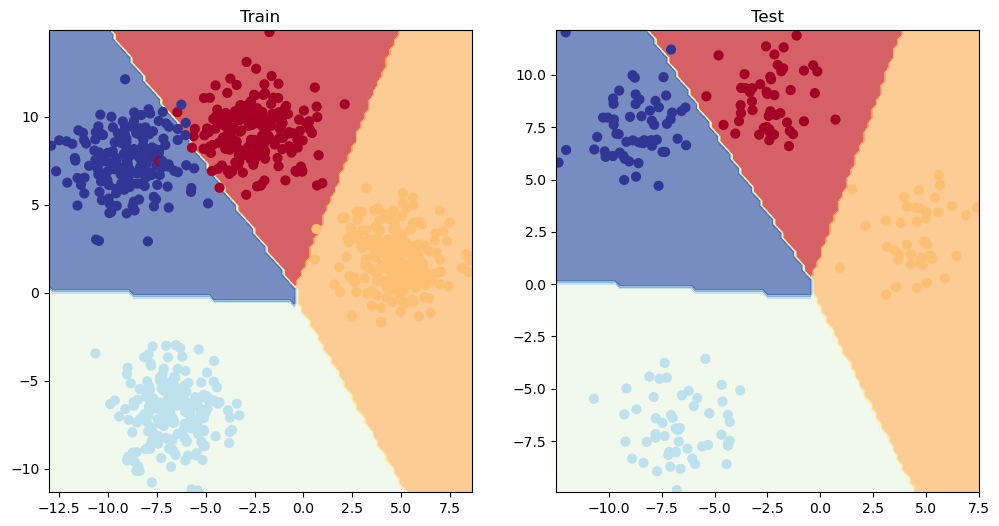

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)